## Plotting the toy dataset

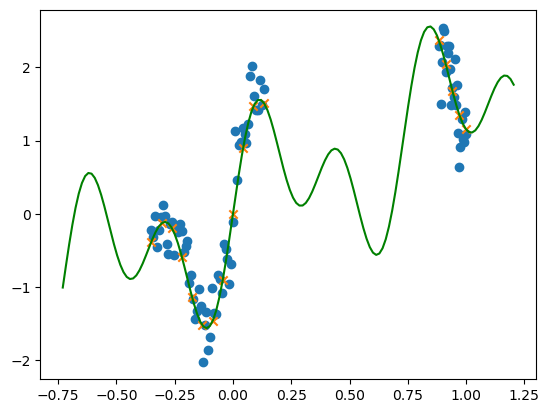

In [2]:
from bnn_src.utils import sum_sinusoid
import matplotlib.pyplot as plt
import torch
#-0.48,#0.21
y,x,y_test,x_test = sum_sinusoid(-0.48,60,0.18)
y2,x2,y_test2,x_test2 = sum_sinusoid(1.21,25,1.37)
y=torch.cat((y,y2),dim=0)
x=torch.cat((x,x2),dim=0)
y_test = torch.cat((y_test,y_test2),dim=0)
x_test = torch.cat((x_test,x_test2), dim=0)

data_max = x.max()
x = x / data_max
x_test = x_test/ data_max

plot_x = torch.linspace(x.min()-0.65,x.max()+0.65,x.shape[0] + x_test.shape[0] + 40)[:,None]
true_func = sum_sinusoid(-0.48,50,1.28,func_return=plot_x)
plt.scatter(x,y)
plt.plot(plot_x/data_max,true_func.numpy(),'g')
plt.scatter(x_test,y_test,marker='x')
plt.show()

## Testing if a simple neural network fits the data well

In [28]:
import torch
import torch.nn as nn


class Net(nn.Module):
    def __init__(self,input_dim=1,activ_func=nn.LeakyReLU):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(1,7)
        self.fc1 = nn.Linear(7,7)
        self.fc2 = nn.Linear(7,1)
        #self.fc3 = nn.Linear(5,1)
        self.non_lin = activ_func()
    def forward(self,inp):
        assert inp.shape[-1] == 1, 'only for stupid regression testing'
        x = self.input_layer(inp)
        x = self.non_lin(x)
        x = self.fc1(x)
        x = self.non_lin(x)
        out = self.fc2(x)
        #out = self.non_lin(x)
        #x = self.fc3(x)
        #out = self.non_lin(x)
        return out

bnn testing model:  Net(
  (input_layer): Linear(in_features=1, out_features=7, bias=True)
  (fc1): Linear(in_features=7, out_features=7, bias=True)
  (fc2): Linear(in_features=7, out_features=1, bias=True)
  (non_lin): ELU(alpha=1.0)
)
loss at epch 0 is 2.1834158897399902


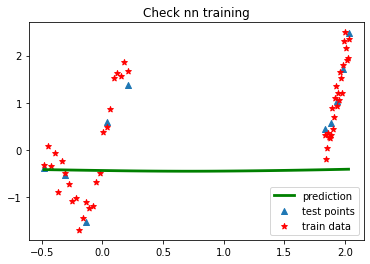

loss at epch 600 is 0.5314363241195679


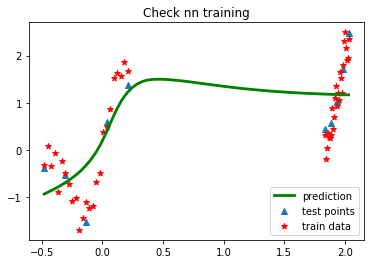

loss at epch 1200 is 0.0740518644452095


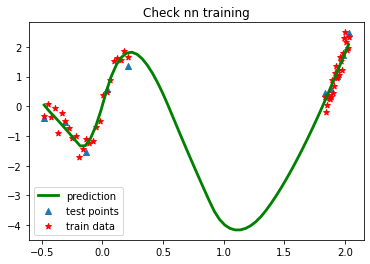

loss at epch 1800 is 0.05510172247886658


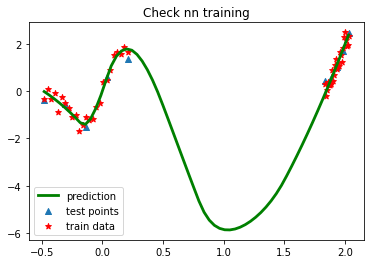

loss at epch 2400 is 0.05407590791583061


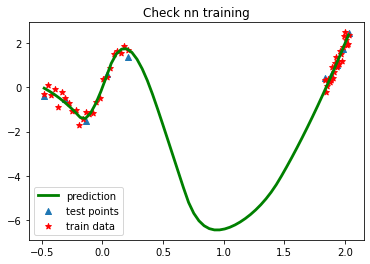

loss at epch 3000 is 0.05337248370051384


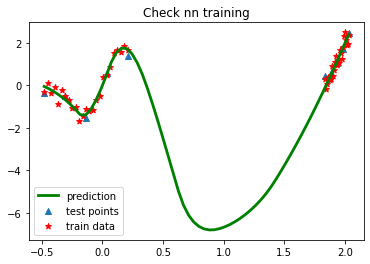

loss at epch 3600 is 0.05276908725500107


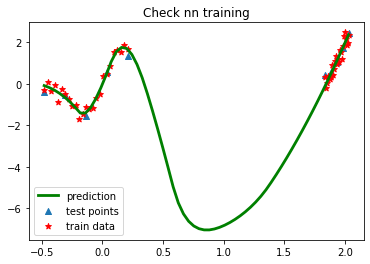

loss at epch 3999 is 0.05246333032846451


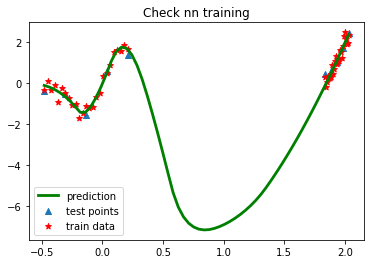

In [30]:
from bnn_src.models import SimpleMLP
from bnn_src.utils import decay_sin,sum_sinusoid
import torch.optim as opt
import numpy as np
import matplotlib.pyplot as plt

itr=4000
device='cuda:0' if torch.cuda.is_available() else 'cpu'

# model = SimpleMLP(input_dim=1,hidden_units=[150,100,80],generator=False,activ_func=nn.Sigmoid)
model1 = Net(activ_func=nn.ELU)
loss_fn = nn.MSELoss()

#data loading and scaling, standard stuff
x_data_shift = 0.0
y_data_shift = 0.0
y,x,y_test,x_test = sum_sinusoid(-0.48,25,0.21)
y2,x2,y_test2,x_test2 = sum_sinusoid(1.84,25,2.03)
y=torch.cat((y,y2),dim=0)
x=torch.cat((x,x2),dim=0)
y_test = torch.cat((y_test,y_test2),dim=0)
x_test = torch.cat((x_test,x_test2), dim=0)
# data_max = x.max()
# x = (x - x_data_shift) / data_max
# x_test = (x_test - x_data_shift) / data_max
y = y + y_data_shift
y_test = y_test + y_data_shift
plot_x = np.linspace(x.min(),x.max(),x.shape[0] + x_test.shape[0])

model1.to(device)
y,x,y_test,x_test = y.to(device), x.to(device), y_test.to(device), x_test.to(device)
plot_x = torch.from_numpy(plot_x)[:,None].to(device,dtype=torch.float32)
optz = opt.Adam(params=model1.parameters(), lr=0.005)
print('bnn testing model: ',model1)

def simple_train_loop(train_x, train_y):
    model1.train()
    out = model1(train_x)
    loss = loss_fn(out,train_y)
    optz.zero_grad()
    loss.backward()
    #print('loss: ', loss.item())
    optz.step()
    return loss.item()
for i in range(itr):
    random_slicing = torch.randperm(x.shape[0])
    train_x = x[random_slicing]
    train_y = y[random_slicing]
    loss = simple_train_loop(train_x, train_y)
    with torch.no_grad():
        test_out = model1(plot_x)
    if i % 600 == 0 or i == itr-1:
        print(f'loss at epch {i} is {loss}')
        plt.plot(plot_x.cpu().numpy(),test_out.cpu().numpy(),'g',label='prediction',lw=2.8)
        plt.scatter(x_test.cpu().numpy(),y_test.cpu().numpy(),marker='^',label='test points')
        plt.scatter(x.cpu().numpy(),y.cpu().numpy(),color='r',marker='*',label='train data')
        plt.legend()
        plt.title('Check nn training')
        plt.show()

# Toy Experiments

## Learning data noise through type 2 ML

No. of BNN parameters: 105
sigma for dlvm set to 0.009
The whole architecture

BayesianMLP(
  (gen_net): SimpleMLP(
    (list_layers): Sequential(
      (0): Linear(in_features=60, out_features=105, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=105, out_features=105, bias=True)
    )
  )
  (list_layers): Sequential(
    (0): GenBayesianLinear(in_features=1, out_features=7, bias=True)
    (1): ELU(alpha=1.0)
    (2): GenBayesianLinear(in_features=7, out_features=10, bias=True)
    (non_lin): ELU(alpha=1.0)
    (last_layer): GenBayesianLinear(in_features=10, out_features=1, bias=True)
  )
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 7496/7500 [02:29<00:00, 50.13it/s]

tensor(0.2742, device='cuda:0')


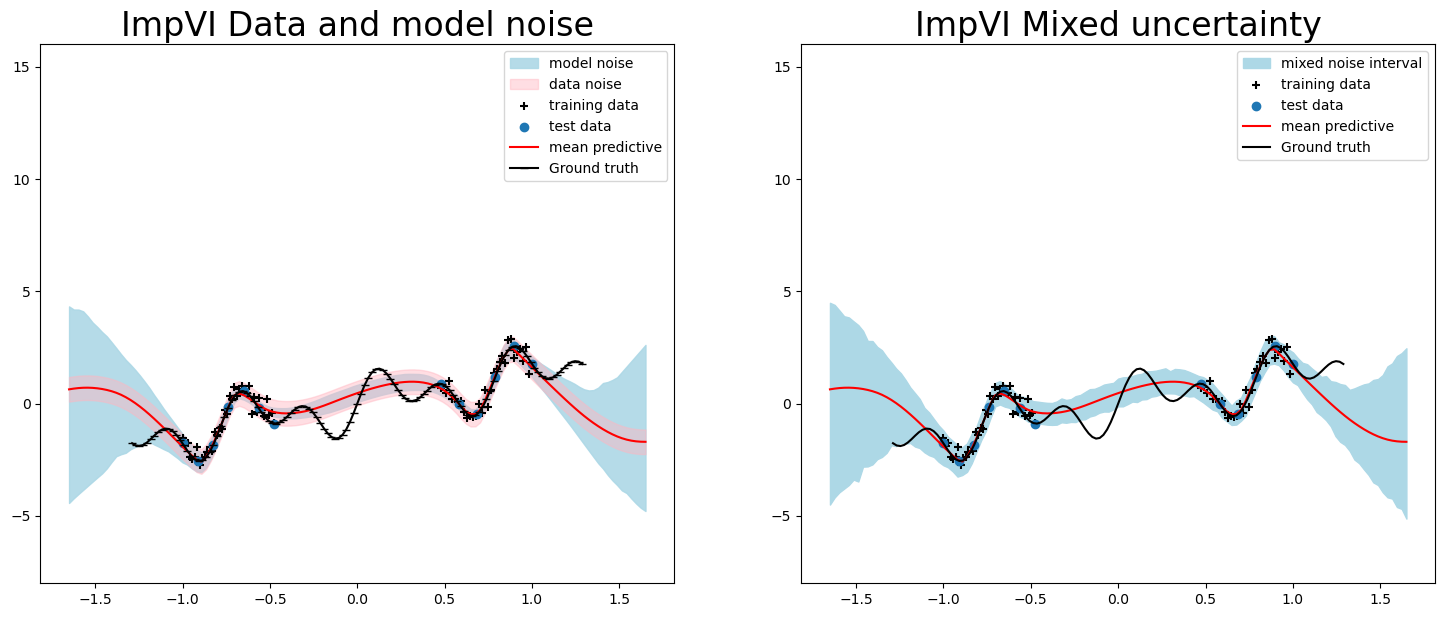

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [02:29<00:00, 50.07it/s]


In [5]:
from bnn_src.models import BayesianMLP
from bnn_src.utils import decay_sin, sum_sinusoid, plotting_code
from bnn_src.imp_bnn import create_generator_nn
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.distributions as dist
from bnn_src.imp_bnn import ImplicitBNNs
#from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim



name_exp = 'epis_aleoteric_gap'
sigma_record_dict = dict()
elbo_record_dict = dict()
itr = 7500
scale = 1.0
x_data_shift = 0.0
y_data_shift = 0.0
assert isinstance(x_data_shift, float), 'data_shift can only be float, extensibility req.'
assert isinstance(y_data_shift, float), 'data_shift can only be float, extensibility req.'

device='cuda:0'

y,x,y_test,x_test = sum_sinusoid(-1.28,38,-0.61)
y2,x2,y_test2,x_test2 = sum_sinusoid(0.61,32,1.28)

y=torch.cat((y,y2),dim=0)
x=torch.cat((x,x2),dim=0)
y_test = torch.cat((y_test,y_test2),dim=0)
x_test = torch.cat((x_test,x_test2), dim=0)
data_max = x.max() #+ tr.abs(tr.randn(1,)).item()
x = (x - x_data_shift) / data_max
x_test = (x_test - x_data_shift) / data_max
y = y + y_data_shift
y_test = y_test + y_data_shift



bnn_gen = create_generator_nn(60, 105, [105, 105], activ_func=nn.ELU)
bnn = BayesianMLP(input_dim=1, hidden_units=[7, 10], generator_network=bnn_gen, device=device, activ_func=nn.ELU)
base_dist = dist.Normal(loc=torch.zeros(bnn.gen_net.input_dim).to(device),
                                    scale=torch.ones(bnn.gen_net.input_dim).to(device))
prior_dist = dist.MultivariateNormal(loc=torch.zeros(bnn.gen_net.list_layers[-1].out_features).to(device),
                                     covariance_matrix= torch.diag(torch.ones(bnn.gen_net.list_layers[-1].out_features)).to(device))

imp_bnn = ImplicitBNNs(bnn,prior_dist,base_dist,small_noise=0.009)

ll_log_var = torch.log(torch.as_tensor(0.01))
ll_log_var = nn.Parameter(ll_log_var)
imp_bnn.bnn.register_parameter('ll_log_var',ll_log_var)

#moving everything to the GPU
imp_bnn.bnn.to(device)
y,x,y_test,x_test = y.to(device), x.to(device), y_test.to(device), x_test.to(device)
print('The whole architecture\n')
print(bnn)
opt = optim.Adam([{'params':imp_bnn.bnn.gen_net.parameters(), 'lr':0.00152},{'params':imp_bnn.bnn.ll_log_var, 'lr':0.000830}]) #not have weight decay when acc jacobi is used

for epch in tqdm(range(itr)):
    ent_down_weigh = 1.0
    log_prob_weight = 0.1 #downweigh the log probability because this regularises the generator strongly.
    random_slicing = torch.randperm(x.shape[0])
    train_x = x[random_slicing]
    train_y = y[random_slicing]
    sigma = torch.exp(0.5*imp_bnn.bnn.ll_log_var) + 1e-8
    sigma_record_dict[epch] = sigma.detach()
    elbo,dl,jac = imp_bnn.full_batch_reparam_elbo_nll([train_x, train_y],n_samples=3, jacobi_down_weight=ent_down_weigh, prob_down_weight=log_prob_weight)

    opt.zero_grad()
    elbo.backward()
    elbo_record_dict[epch] = elbo.detach()
    opt.step()
    if epch == itr - 1:
        print(sigma_record_dict[itr-1])
        _, _, _ = plotting_code(y, x, y_test, x_test, imp_bnn, save=False, device=device, plotting_samples=250,gaussian_noise_ll=sigma.detach(), standardised=True,data_max=data_max)


max std of weights after training with full lower bound and accurate jacobian: 8.681347846984863
shape of the weight sample generated, i.e. number of params in the bnn: torch.Size([200, 105])


/home/ansup/.conda/envs/.venv_fi/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ansup/.conda/envs/.venv_fi/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ansup/.conda/envs/.venv_fi/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

<AxesSubplot:ylabel='Density'>

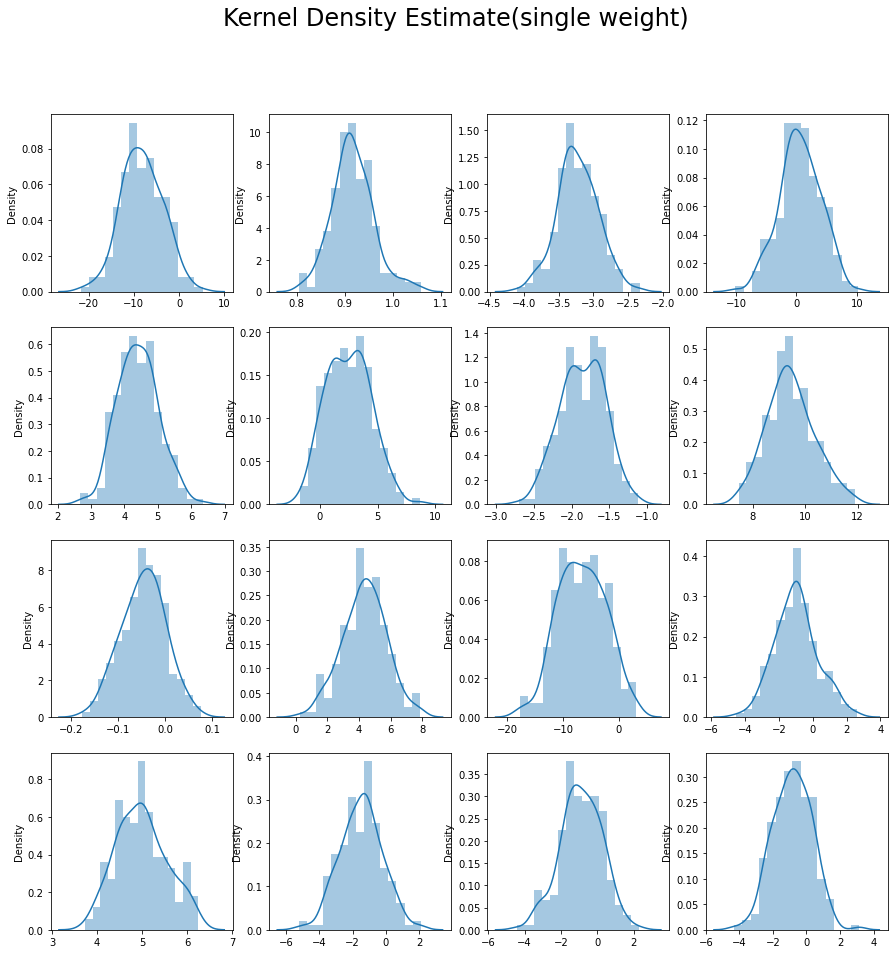

In [17]:
import torch as tr
bnn.gen_net.eval()
b_sample, w_sample, w_to_l = bnn.sample_params(batch_size=40, device='cuda:0')
std = tr.std(w_sample.detach(),dim=0)
print(f'max std of weights after training with full lower bound and accurate jacobian: {std.max()}')# max spread of the weights that we get from the generator
import seaborn as sns
import matplotlib.pyplot as plt
bnn.gen_net.eval()
b_sample, w_sample, w_to_l = bnn.sample_params(batch_size=200,device='cuda:0') #generate 100 weight samples for plotting given trained generator
print(f'shape of the weight sample generated, i.e. number of params in the bnn: {w_sample.shape}')
fig, axes = plt.subplots(4,4, figsize=(15,15))
fig.suptitle("Kernel Density Estimate(single weight)",fontsize=24)
sns.distplot(w_sample.detach().cpu()[:,71], ax=axes[0,0],bins=15)
sns.distplot(w_sample.detach().cpu()[:,12], ax=axes[0,1],bins=15)
sns.distplot(w_sample.detach().cpu()[:,2], ax=axes[0,2],bins=15)
sns.distplot(w_sample.detach().cpu()[:,65], ax=axes[0,3],bins=15)
sns.distplot(w_sample.detach().cpu()[:,30], ax=axes[1,0],bins=15)
sns.distplot(w_sample.detach().cpu()[:,53], ax=axes[1,1],bins=15)
sns.distplot(w_sample.detach().cpu()[:,7], ax=axes[1,2],bins=15)
sns.distplot(w_sample.detach().cpu()[:,44], ax=axes[1,3],bins=15)
sns.distplot(w_sample.detach().cpu()[:,5], ax=axes[2,0],bins=15)
sns.distplot(w_sample.detach().cpu()[:,14], ax=axes[2,1],bins=15)
sns.distplot(w_sample.detach().cpu()[:,22], ax=axes[2,2],bins=15)
sns.distplot(w_sample.detach().cpu()[:,58], ax=axes[2,3],bins=15)
sns.distplot(w_sample.detach().cpu()[:,37], ax=axes[3,0],bins=15)
sns.distplot(w_sample.detach().cpu()[:,55], ax=axes[3,1],bins=15)
sns.distplot(w_sample.detach().cpu()[:,62], ax=axes[3,2],bins=15)
sns.distplot(w_sample.detach().cpu()[:,42], ax=axes[3,3],bins=15)

#fig.savefig('toy_plt_kde.pdf',format='pdf')

(105,)
[  0   3  77  98   6   2  10  25  13  99   9  11  27  23  88  32  92  60
  49  24  28  56  70  84  63   1  21  58  67  30   5  50  62  47  75  34
  59  37  52  65  55  31 104  78  69  40  22   8  79  83  66  93  35  36
  29  82  42  51  54  91  19  89  57  39  97  87  80  38  90  61  64  86
  68  33  41  43  15  26  71  18  14  81  12  85  46 101  74 100  96  16
  20  72  76  53  44  95  48  17  73  94 102   4  45   7 103]


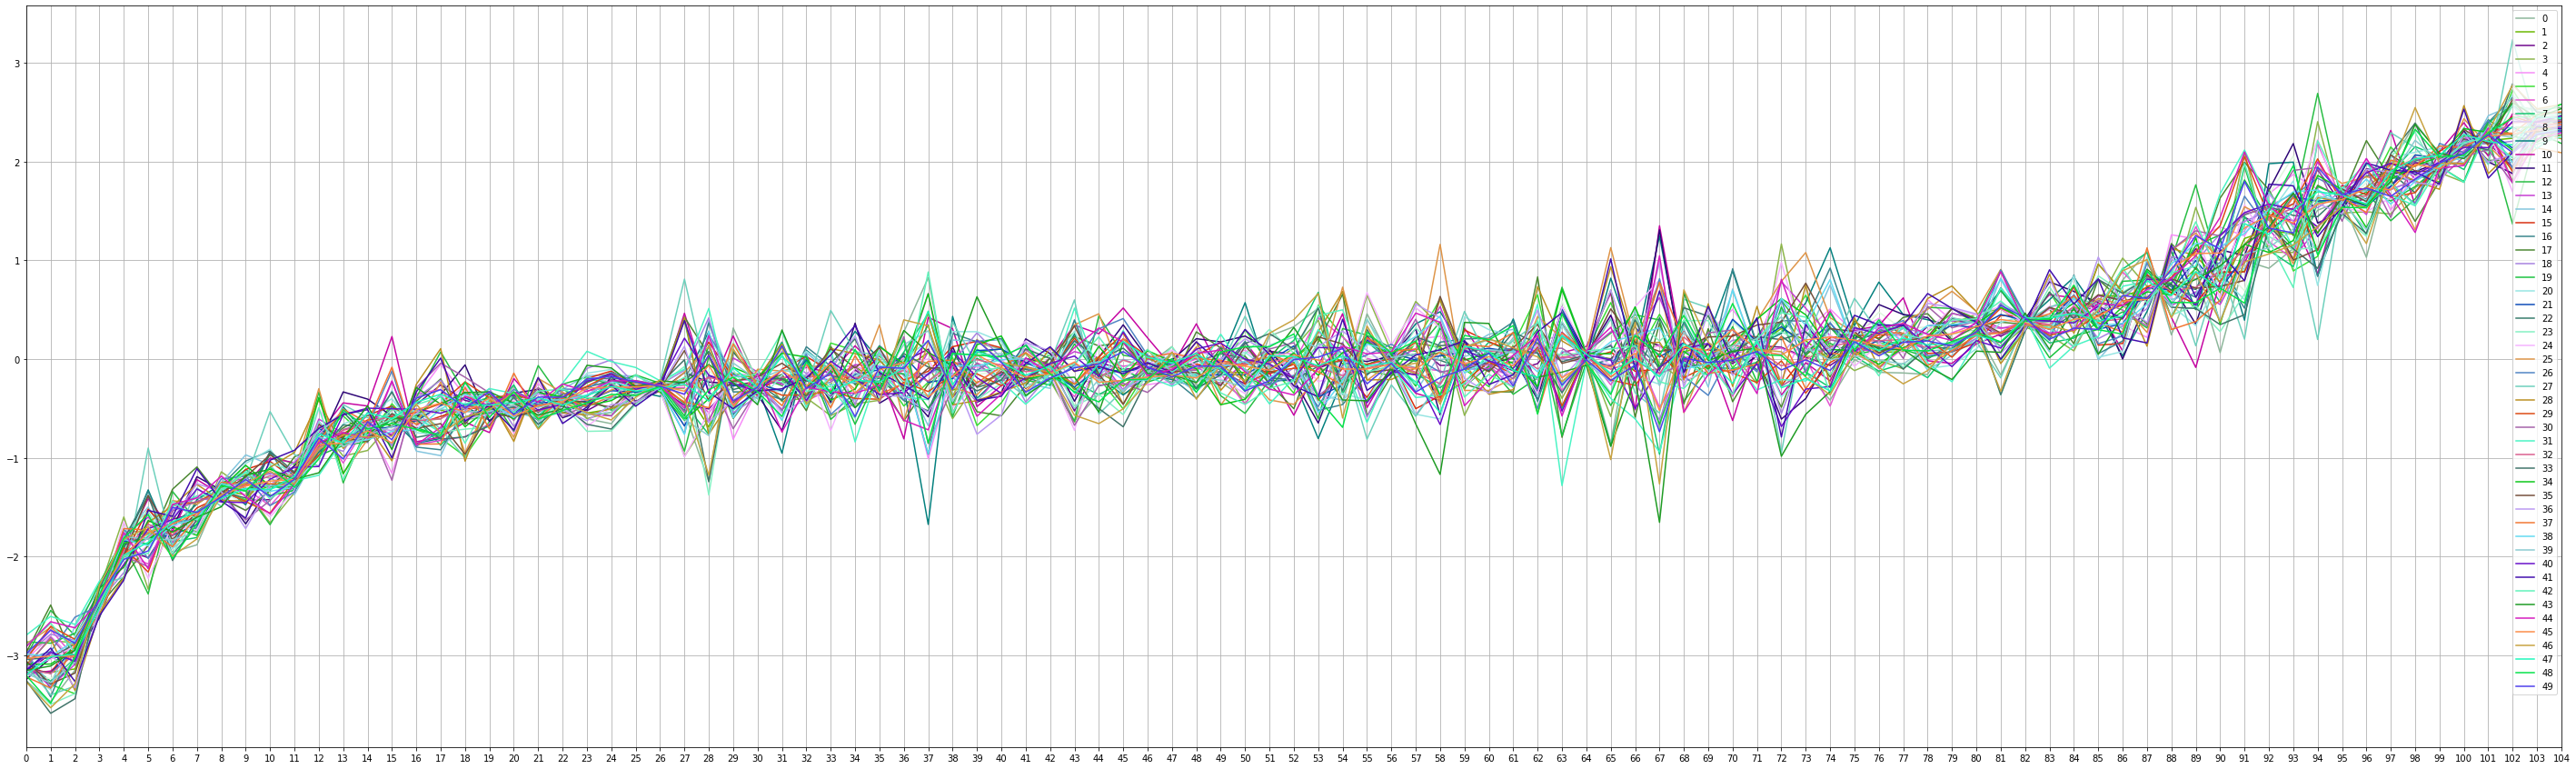

In [21]:
# generate the parallel coordinate plot here
# to understand this plot please refer to - Shi et. al. 2018, see appendix F.3, Kernel Implicit VI

from pandas.plotting import parallel_coordinates
import pandas as pd
import torch as tr
import matplotlib.pyplot as plt
import numpy as np

bnn.gen_net.eval()
b_sample, w_sample, w_to_l = bnn.sample_params(batch_size=50, device='cuda:0')
mean_weights = np.mean(w_sample.detach().cpu().numpy(),axis=0)
print(mean_weights.shape)
sort_index = np.argsort(mean_weights)
print(sort_index)
df = pd.DataFrame(w_sample.detach().cpu().numpy()[:,sort_index])

a = [str(i) for i in list(np.arange(50))]
df2 = df.assign(Weights_samp = a)
fig, ax = plt.subplots(figsize=(50,15))
parallel_coordinates(df2,'Weights_samp',axvlines=False,ax=ax)
plt.savefig("prior_zeroF2.pdf",format='pdf')
plt.show()

## Training with the differential lower bound

No. of BNN parameters: 105
sigma for dlvm set to 0.003
The whole architecture

BayesianMLP(
  (gen_net): SimpleMLP(
    (list_layers): Sequential(
      (0): Linear(in_features=85, out_features=100, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=100, out_features=105, bias=True)
    )
  )
  (list_layers): Sequential(
    (0): GenBayesianLinear(in_features=1, out_features=7, bias=True)
    (1): ELU(alpha=1.0)
    (2): GenBayesianLinear(in_features=7, out_features=10, bias=True)
    (non_lin): ELU(alpha=1.0)
    (last_layer): GenBayesianLinear(in_features=10, out_features=1, bias=True)
  )
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 7996/8000 [04:00<00:00, 32.93it/s]

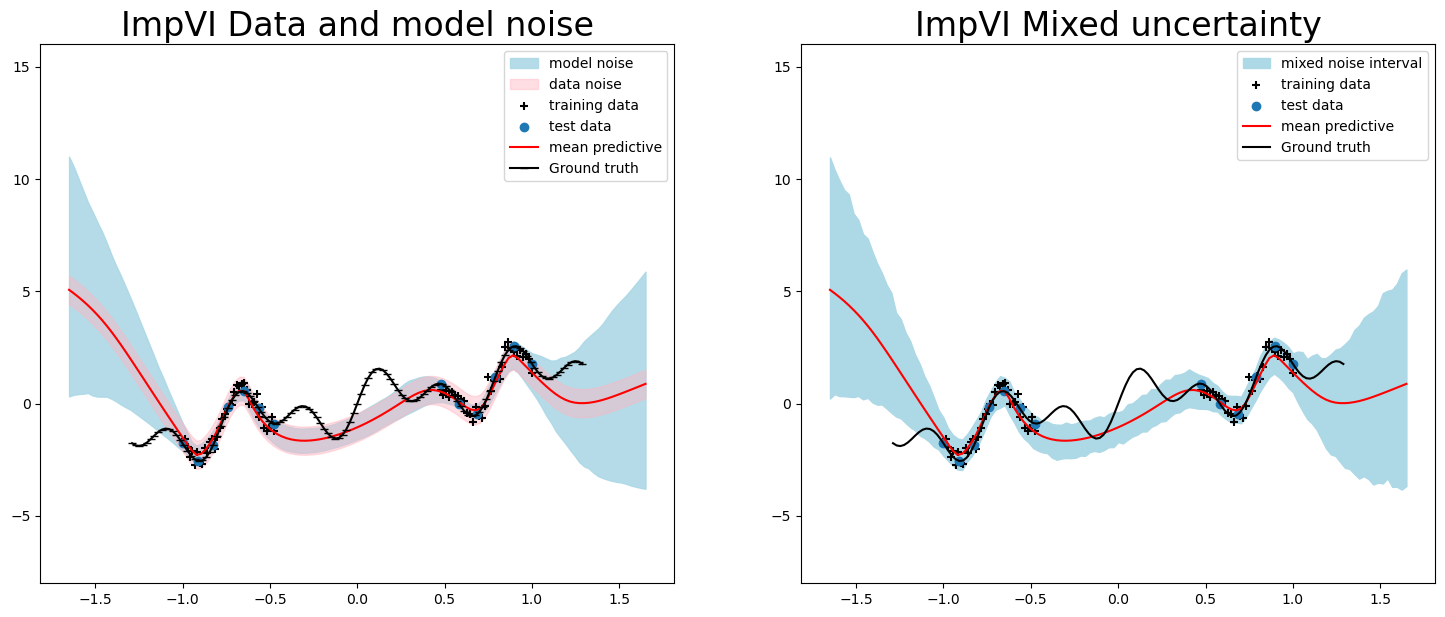

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [04:01<00:00, 33.15it/s]

Sigma:  tensor(0.3134, device='cuda:0')


In [2]:
from bnn_src.models import BayesianMLP
from bnn_src.utils import decay_sin, sum_sinusoid, plotting_code
from bnn_src.imp_bnn import create_generator_nn
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.distributions as dist
from bnn_src.imp_bnn import ImplicitBNNs
#from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim



name_exp = 'epis_aleoteric_gap_diff_lb'
sigma_record_dict = dict()
elbo_record_dict = dict()
itr = 8000
x_data_shift = 0.0
y_data_shift = 0.0
assert isinstance(x_data_shift, float), 'data_shift can only be float, extensibility req.'
assert isinstance(y_data_shift, float), 'data_shift can only be float, extensibility req.'
#writer = SummaryWriter()  # the add_graph will not work with the bnn training generator parameters

device='cuda:0'

y,x,y_test,x_test = sum_sinusoid(-1.28,38,-0.61)
y2,x2,y_test2,x_test2 = sum_sinusoid(0.61,32,1.28)

y=torch.cat((y,y2),dim=0)
x=torch.cat((x,x2),dim=0)
y_test = torch.cat((y_test,y_test2),dim=0)
x_test = torch.cat((x_test,x_test2), dim=0)
data_max = x.max() #+ tr.abs(tr.randn(1,)).item()
x = (x - x_data_shift) / data_max
x_test = (x_test - x_data_shift) / data_max
y = y + y_data_shift
y_test = y_test + y_data_shift


bnn_gen = create_generator_nn(85, 105, [100, 105], activ_func=nn.ELU)
bnn = BayesianMLP(input_dim=1, hidden_units=[7, 10], generator_network=bnn_gen, device=device, activ_func=nn.ELU)
base_dist = dist.Normal(loc=torch.zeros(bnn.gen_net.input_dim).to(device),
                                    scale=torch.ones(bnn.gen_net.input_dim).to(device))
prior_dist = dist.MultivariateNormal(loc=torch.zeros(bnn.gen_net.list_layers[-1].out_features).to(device),
                                     covariance_matrix= torch.diag(torch.ones(bnn.gen_net.list_layers[-1].out_features)).to(device))

imp_bnn = ImplicitBNNs(bnn,prior_dist,base_dist, small_noise=0.003)

ll_log_var = torch.log(torch.as_tensor(0.01))
ll_log_var = nn.Parameter(ll_log_var)
imp_bnn.bnn.register_parameter('ll_log_var',ll_log_var)

#moving everything to the GPU
imp_bnn.bnn.to(device)
y,x,y_test,x_test = y.to(device), x.to(device), y_test.to(device), x_test.to(device)
print('The whole architecture\n')
print(bnn)
opt = optim.Adam([{'params':imp_bnn.bnn.gen_net.parameters(), 'lr':0.0018},{'params':imp_bnn.bnn.ll_log_var,'lr':0.0008}]) #not have weight decay when acc jacobi is used


for epch in tqdm(range(itr)):
    ent_down_weigh = 1.0
    log_prob_weight = 0.1
    random_slicing = torch.randperm(x.shape[0])
    train_x = x[random_slicing]
    train_y = y[random_slicing]
    sigma = torch.exp(0.5*imp_bnn.bnn.ll_log_var) + 1e-8
    sigma_record_dict[epch] = sigma.detach()
    elbo,dl,jac = imp_bnn.full_batch_reparam_elbo_nll([train_x, train_y],n_samples=3, jacobi_down_weight=ent_down_weigh, prob_down_weight=log_prob_weight,accurate=False)

    opt.zero_grad()
    elbo.backward()
    elbo_record_dict[epch] = elbo.detach()

    opt.step()
    if epch == itr - 1:
        _,_,_ = plotting_code(y, x, y_test, x_test, imp_bnn, save=False, device=device, plotting_samples=250, gaussian_noise_ll=sigma.detach(), standardised=True,data_max=data_max)
        print('Sigma: ', sigma_record_dict[itr-1])


(105,)
[  6  57  33   2  89  11  50  13  36  54   9 103  61  74  71 102  47  75
  76  43  40  87  97  10   3  82 101  98  85   7  90   0  93  63  91  18
  72  17  65  29  46  21  88  73  78  24  15 104  51  39  45  14  19  86
  64  96  26  32  92  84  60  22  42  59   5  66  70  12  68  69 100  30
  77  44  83  80  94  53   8  95  79   1  99  56  35  23  16  28  52  58
  34  38  49  62  55  27  20  67  37  31  48   4  81  41  25]


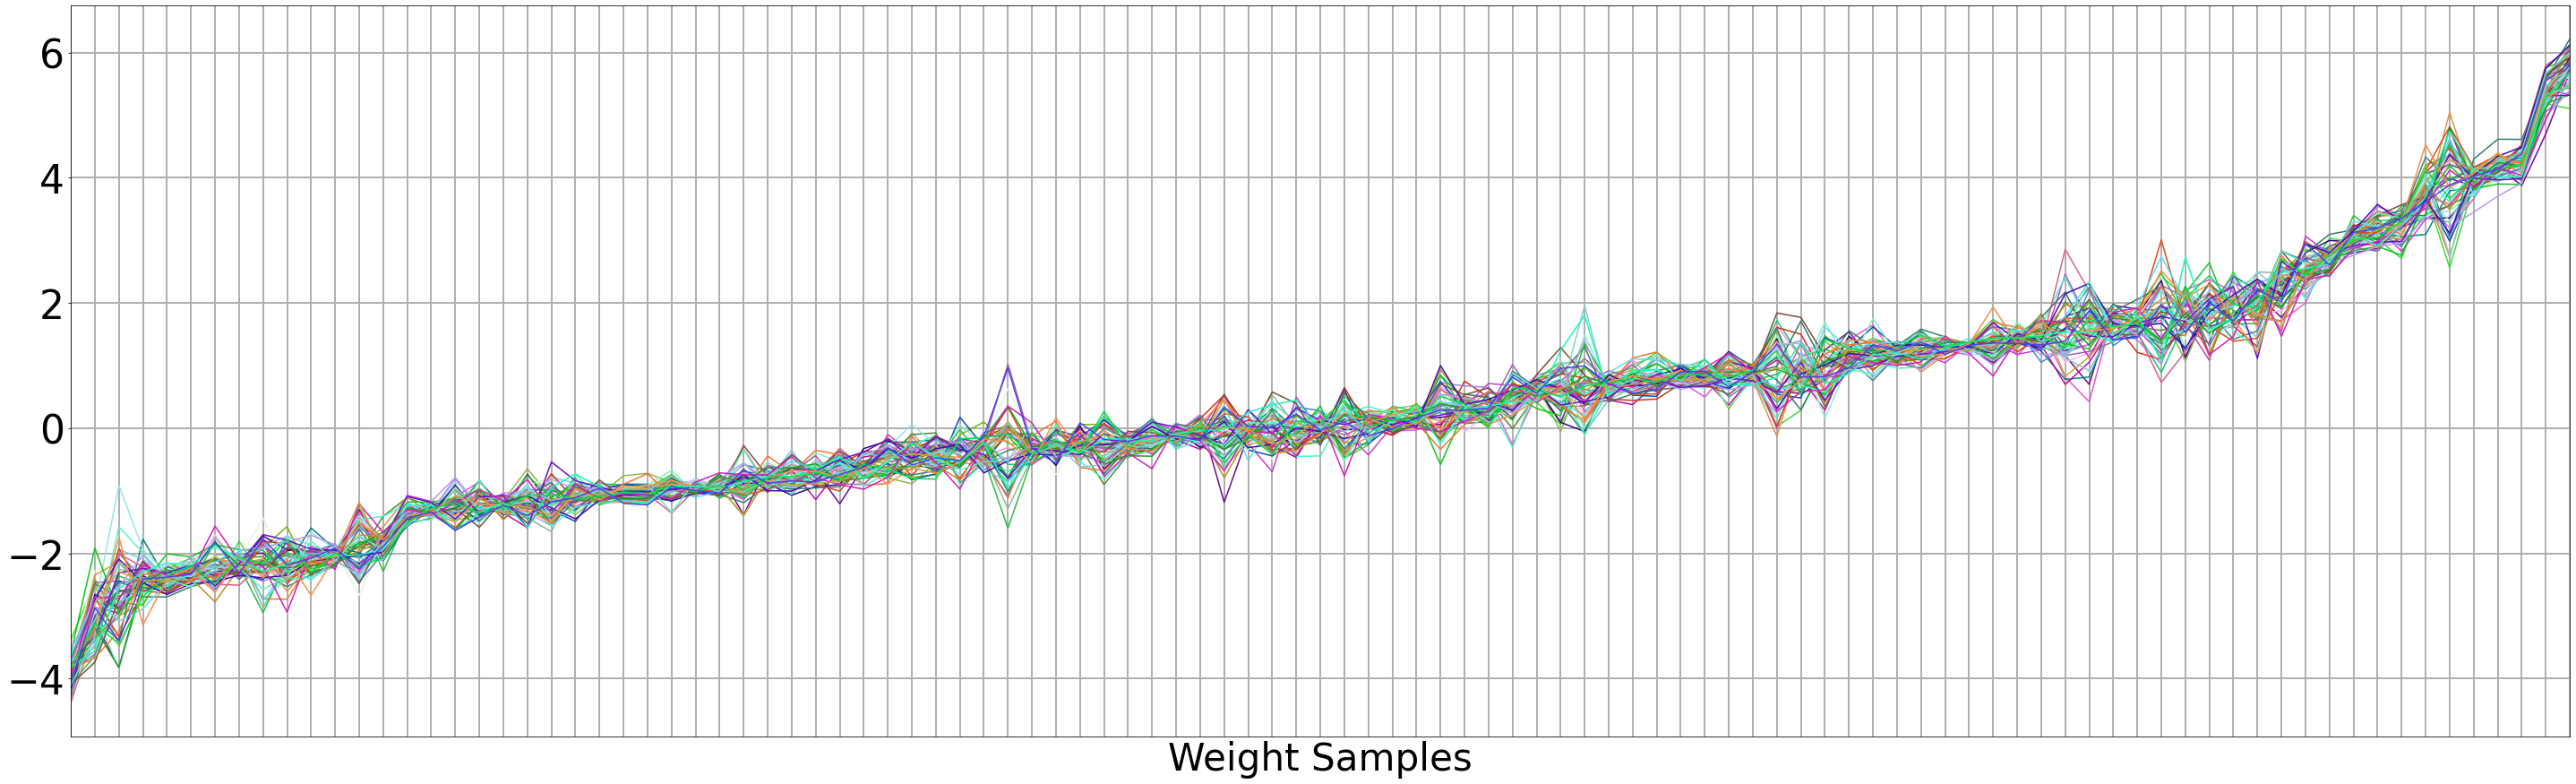

In [43]:
from pandas.plotting import parallel_coordinates
import pandas as pd
import torch as tr
import matplotlib.pyplot as plt
import numpy as np

imp_bnn.bnn.gen_net.eval()
b_sample, w_sample, w_to_l = imp_bnn.bnn.sample_params(batch_size=50, device='cuda:0')
mean_weights = np.mean(w_sample.detach().cpu().numpy(),axis=0)
print(mean_weights.shape)
sort_index = np.argsort(mean_weights)
print(sort_index)
df = pd.DataFrame(w_sample.detach().cpu().numpy()[:,sort_index])

a = [str(i) for i in list(np.arange(50))]
df2 = df.assign(Weights_samp = a)
fig, ax = plt.subplots(figsize=(50,15))
parallel_coordinates(df2,'Weights_samp',axvlines=False,ax=ax)
plt.yticks(fontsize=44)
plt.xlabel('Weight Samples',fontsize=42)
#plt.xticks([],frameon=False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend('',frameon=False)
plt.grid(lw=2)
plt.savefig("prior_zeroF2.pdf",format='pdf')
plt.show()
